In [1]:
import pandas as pd
import sqlite3

Load the Excel file

In [7]:
df = pd.read_csv("Sample - Superstore.csv", encoding='latin1')


In [8]:
df.columns = [col.strip().lower() for col in df.columns]


Create a SQLite in-memory database

In [9]:
conn = sqlite3.connect(":memory:")


Save DataFrame to a SQL table

In [10]:
df.to_sql("superstore", conn, index=False, if_exists='replace')


9994

What are the top 5 selling products?


In [94]:
query = """
select
	round(sum(sales),1) as Total_Sales, `product name`
from superstore
group by `product name`
order by Total_Sales desc
limit 5;

"""

top_products = pd.read_sql_query(query, conn)
top_products


,Total_Sales,Product Name
0,61599.8,Canon imageCLASS 2200 Advanced Copier
1,27453.4,Fellowes PB500 Electric Punch Plastic Comb Bin...
2,22638.5,Cisco TelePresence System EX90 Videoconferenci...
3,21870.6,HON 5400 Series Task Chairs for Big and Tall
4,19823.5,GBC DocuBind TL300 Electric Binding System


In [95]:

import altair as alt

# Calculate the total sales to compute percentages
total_sales = top_products['Total_Sales'].sum()

# Add a percentage column
top_products['percentage'] = top_products['Total_Sales'] / total_sales

# Create the base chart
base = alt.Chart(top_products).encode(
    theta=alt.Theta("Total_Sales", stack=True)
)

# Create the pie chart with arcs
pie = base.mark_arc(outerRadius=120).encode(
    color=alt.Color("Product Name"),
    order=alt.Order("Total_Sales", sort="descending"),
    tooltip=["Product Name", "Total_Sales", alt.Tooltip("percentage", format=".1%")]
)

# Add text labels with percentages
text = base.mark_text(radius=140).encode(
    text=alt.Text("percentage", format=".1%"),
    order=alt.Order("Total_Sales", sort="descending"),
    color=alt.value("black")  # Set the color of the labels to black
)

# Combine the pie chart and the text
chart = pie + text
chart

alt.LayerChart(...)

#Which category generates the most revenue?


In [48]:
query = """
select
	category, round(sum(sales), 1) as Total_Sales
from superstore
group by category
order by Total_Sales desc
limit 1;


"""

top_products = pd.read_sql_query(query, conn)
top_products


,Category,Total_Sales
0,Technology,836154.0


#How do monthly sales trend over time?


In [33]:
df.columns = df.columns.str.strip().str.title()  # Title-case and strip whitespace


In [36]:
if df.columns.duplicated().any():
    print("Duplicate columns found:", df.columns[df.columns.duplicated()])
    df = df.loc[:, ~df.columns.duplicated()]  # Remove duplicated columns


Duplicate columns found: Index(['Order Date'], dtype='object')


In [37]:
df.to_sql("superstore", conn, index=False, if_exists="replace")


9994

In [65]:


query = """
SELECT
    strftime('%Y-%m', "order date") AS order_month,
    ROUND(SUM(sales), 1) AS Total_Sales
FROM superstore
GROUP BY order_month
ORDER BY order_month ASC;



"""

top_products = pd.read_sql_query(query, conn)
top_products


,order_month,Total_Sales
0,2014-01,14236.9
1,2014-02,4519.9
2,2014-03,55691.0
3,2014-04,28295.3
4,2014-05,23648.3
5,2014-06,34595.1
6,2014-07,33946.4
7,2014-08,27909.5
8,2014-09,81777.4
9,2014-10,31453.4


In [54]:
top_products['order_month'] = pd.to_datetime(top_products['order_month'])


In [57]:
top_products['Moving_Avg'] = top_products['Total_Sales'].rolling(window=3).mean()


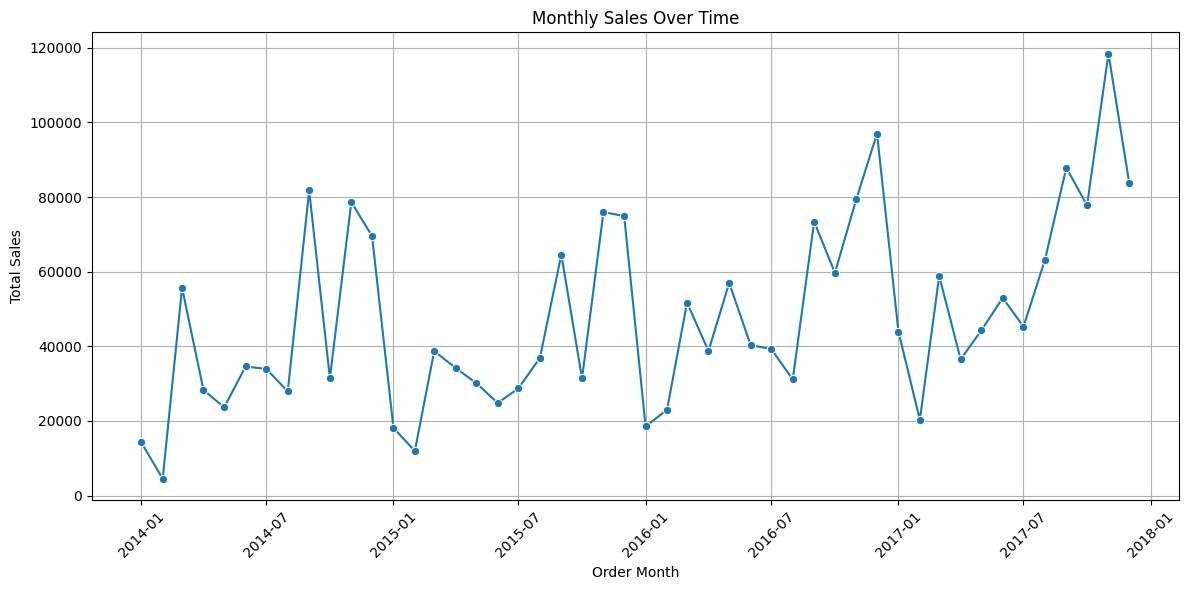

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_products, x='order_month', y='Total_Sales', marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Order Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#Who are the top 10 customers by lifetime value?


In [64]:


query = """
select
	`customer name`,
	round(sum(sales),1) as Total_Sale
from superstore
group by `customer name`
order by Total_sale desc
limit 10;



"""

top_products = pd.read_sql_query(query, conn)
top_products


,Customer Name,Total_Sale
0,Sean Miller,25043.1
1,Tamara Chand,19052.2
2,Raymond Buch,15117.3
3,Tom Ashbrook,14595.6
4,Adrian Barton,14473.6
5,Ken Lonsdale,14175.2
6,Sanjit Chand,14142.3
7,Hunter Lopez,12873.3
8,Sanjit Engle,12209.4
9,Christopher Conant,12129.1


In [63]:

import altair as alt
# Create a bar chart of the top products by total sale, encoding Customer Name on the x-axis and Total_Sale on the y-axis.
# Adjust the chart size to make it 800 pixels wide and 400 pixels high.
chart = alt.Chart(top_products).mark_bar().encode(x='Customer Name', y='Total_Sale').properties(width=800, height=400)
# Display the chart.
chart

alt.Chart(...)

#Which product sub-categories have the lowest profit margins?


In [66]:

query = """
select
	`Sub-Category`,
	round(sum(profit)/sum(sales) *100,1) as Profit_Margine_Percentage
from superstore
group by `Sub-Category`
order by Profit_Margine_Percentage asc;


"""

top_products = pd.read_sql_query(query, conn)


In [68]:

chart = alt.Chart(top_products).mark_bar().encode(
    x=alt.X('Sub-Category', axis=alt.Axis(title='Sub-Category')),
    y=alt.Y('Profit_Margine_Percentage', axis=alt.Axis(title='Profit Margin Percentage (%)', grid=True, gridDash=[1, 5], format='.1f'))
).properties(
    title='Profit Margin Percentage by Sub-Category',
    width=800,
    height=400
).interactive() # Add interactivity for zooming and panning

chart

alt.Chart(...)

#What is the average delivery time per shipping mode?


In [72]:
df.loc[:, 'Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df.loc[:, 'Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')


In [73]:
df.to_sql("superstore", conn, if_exists="replace", index=False)


9994

In [75]:

query = """
SELECT
    `ship mode`,
    ROUND(AVG(julianday(`ship date`) - julianday(`order date`)), 1) AS `average ship time`
FROM superstore
GROUP BY `ship mode`
order by `average ship time`;
"""

top_products = pd.read_sql_query(query, conn)
top_products

,Ship Mode,average ship time
0,Same Day,0.0
1,First Class,2.2
2,Second Class,3.2
3,Standard Class,5.0


#Are there seasonal patterns in sales?   


In [78]:

query = """
SELECT
    strftime('%m', `order date`) AS month,
    strftime('%Y', `order date`) AS year,
    ROUND(SUM(sales), 1) AS total_sales
FROM superstore
GROUP BY year, month
ORDER BY year, month;


"""

top_products = pd.read_sql_query(query, conn)


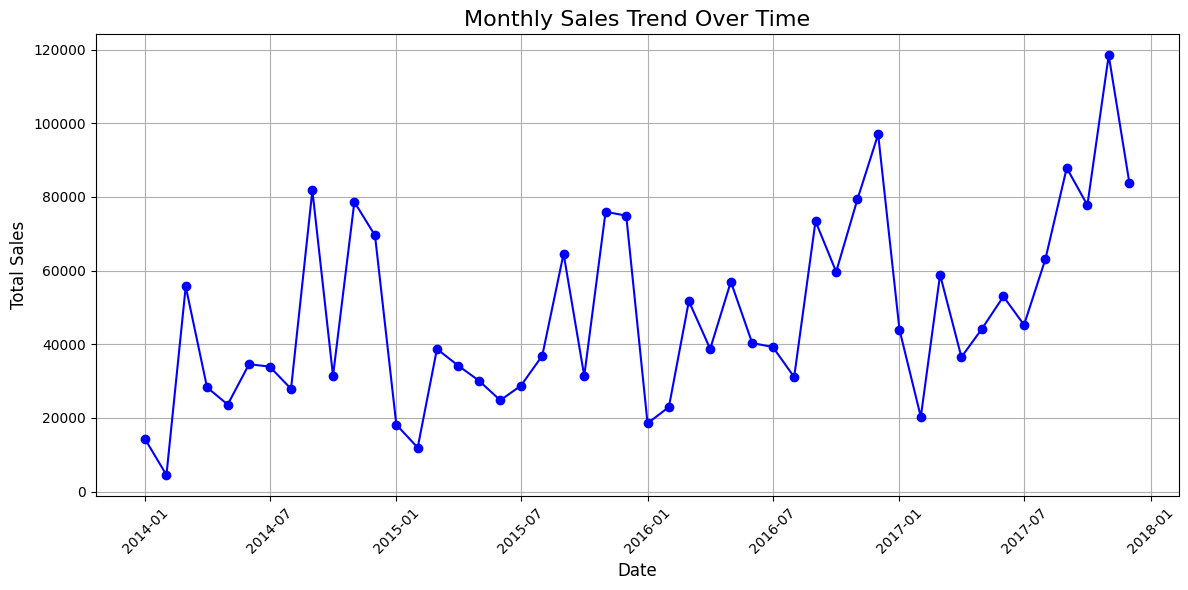

In [79]:
import matplotlib.pyplot as plt

# Convert 'year' and 'month' columns to a datetime format for proper plotting
top_products['date'] = pd.to_datetime(top_products['year'] + '-' + top_products['month'])

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(top_products['date'], top_products['total_sales'], marker='o', linestyle='-', color='b')
plt.title('Monthly Sales Trend Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Which quarter of the year brings in the highest average profit?


In [80]:
# %% [markdown]
# #Which quarter of the year brings in the highest average profit?
#
# %%

query = """
select
	CASE
        WHEN CAST(strftime('%m', `order date`) AS INTEGER) BETWEEN 1 AND 3 THEN 1
        WHEN CAST(strftime('%m', `order date`) AS INTEGER) BETWEEN 4 AND 6 THEN 2
        WHEN CAST(strftime('%m', `order date`) AS INTEGER) BETWEEN 7 AND 9 THEN 3
        WHEN CAST(strftime('%m', `order date`) AS INTEGER) BETWEEN 10 AND 12 THEN 4
    END as quarters,
	round(avg(profit),1) as avg_profit
from superstore
group by quarters
order by quarters;
"""

top_products = pd.read_sql_query(query, conn)
top_products

,quarters,avg_profit
0,1,34.9
1,2,26.1
2,3,25.9
3,4,29.9


#Top 3 regions where the average profit per order is highest.


In [89]:

query = """
with profit_per_region as(
select
	region,
	round(
	sum(profit)/ sum(sales)*100,1) as Profit_Per_Sale
from superstore
group by region
)
select region,profit_per_sale
from profit_per_region
order by profit_per_sale desc
limit 3;
"""

top_products = pd.read_sql_query(query, conn)
top_products

,region,Profit_Per_Sale
0,West,14.9
1,East,13.5
2,South,11.9


#Identify the top 5 customers who had the highest average order value — but only for orders shipped with 'First Class'.


In [92]:
query = """
WITH first_class AS (
    SELECT
        `Order ID`, `Customer ID`, `Customer Name`,
        SUM(Sales) AS order_value
    FROM superstore
    WHERE `Ship Mode` = 'First Class'
    GROUP BY `Order ID`, `Customer ID`, `Customer Name`
)
SELECT
    `Customer ID`, `Customer Name`,
    ROUND(AVG(order_value), 1) AS avg_order_value
FROM first_class
GROUP BY `Customer ID`, `Customer Name`
ORDER BY avg_order_value DESC
LIMIT 5;
"""

top_products = pd.read_sql_query(query, conn)
top_products


,Customer ID,Customer Name,avg_order_value
0,RB-19360,Raymond Buch,14052.5
1,NC-18535,Nick Crebassa,5282.6
2,TA-21385,Tom Ashbrook,4602.6
3,MW-18220,Mitch Webber,3519.4
4,NP-18325,Naresj Patel,3385.6
